In [3]:
from sklearn.model_selection import train_test_split
import pandas as pd

data = pd.read_csv("../data/processed/payments_categorized.tsv", sep='\t', header=None, names=['date', 'amount', 'description', 'category'])
data.drop(index=0, inplace=True)
data = data.dropna(subset=['category'])
train_data, val_data = train_test_split(data, test_size=0.2, stratify=data['category'], random_state=42)

# Сохранение val_data для тестирования
val_data.to_csv("../data/processed/val_data.tsv", sep='\t', index=False)

Inferencing: 100%|██████████| 74/74 [00:16<00:00,  4.48it/s]


                precision    recall  f1-score   support

  BANK_SERVICE       0.69      0.66      0.68       307
    FOOD_GOODS       0.70      0.70      0.70       958
       LEASING       0.70      0.72      0.71       368
          LOAN       0.71      0.69      0.70       415
NON_FOOD_GOODS       0.66      0.71      0.68       713
NOT_CLASSIFIED       0.63      0.62      0.63       252
   REAL_ESTATE       0.65      0.67      0.66       287
       SERVICE       0.71      0.71      0.71       991
           TAX       0.68      0.61      0.65       443

      accuracy                           0.69      4734
     macro avg       0.68      0.68      0.68      4734
  weighted avg       0.69      0.69      0.69      4734



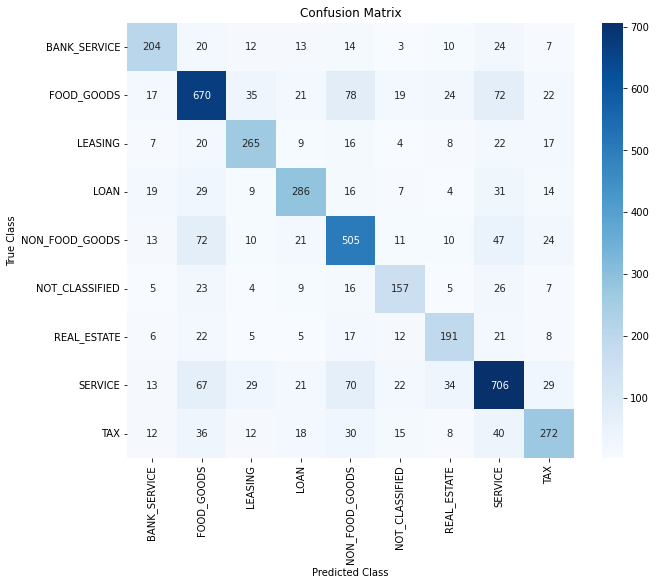

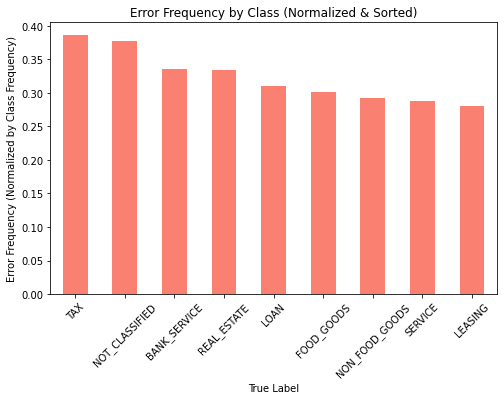

<ipython-input-6-067d7c64520f>:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pair_errors.head(10), x='is_error', y='pair', palette="viridis")


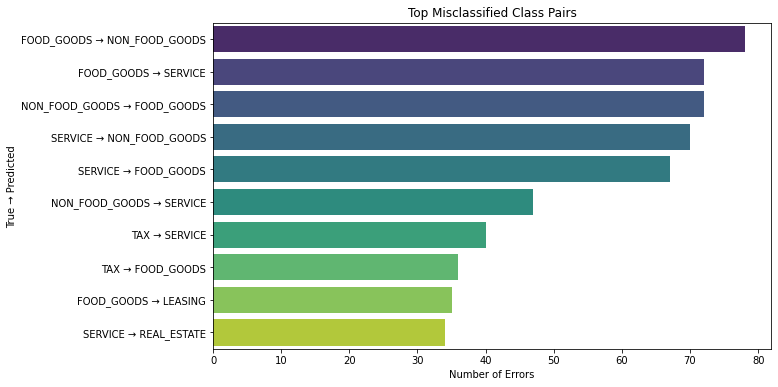

In [6]:
import pandas as pd
from transformers import AutoTokenizer
import onnxruntime as ort
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# Параметры
VAL_DATA_PATH = "../data/processed/val_data.tsv"
MODEL_PATH = "../models/onnx_model/model_quantized.onnx"
TOKENIZER_PATH = "../models/onnx_model"
BATCH_SIZE = 64
MAX_LENGTH = 128
# Функции
def preprocess_data(df):
    df['text'] = df.apply(lambda x: f"{x['date']} [SEP] {x['amount']} [SEP] {x['description']}", axis=1)
    return df['text'], df['category']

def tokenize_data(batch, tokenizer, max_length):
    encoding = tokenizer(batch, padding=True, truncation=True, max_length=max_length, return_tensors="np")
    return encoding

def load_onnx_model(onnx_model_path):
    return ort.InferenceSession(onnx_model_path, providers=['CPUExecutionProvider'])

def infer_batch(session, inputs):
    ort_inputs = {k: v for k, v in inputs.items()}
    ort_outputs = session.run(None, ort_inputs)
    return np.argmax(ort_outputs[0], axis=1)

# Загрузка данных
val_data = pd.read_csv(VAL_DATA_PATH, sep='\t')
val_texts, val_labels = preprocess_data(val_data)
val_labels = val_labels.astype('category')
label_mapping = dict(enumerate(val_labels.cat.categories))
val_labels = val_labels.cat.codes

# Токенизация и модель
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_PATH)
session = load_onnx_model(MODEL_PATH)

# Инференс
predictions = []
for i in tqdm(range(0, len(val_texts), BATCH_SIZE), desc="Inferencing"):
    batch_texts = val_texts[i:i + BATCH_SIZE].tolist()
    tokenized_batch = tokenize_data(batch_texts, tokenizer, MAX_LENGTH)
    batch_predictions = infer_batch(session, tokenized_batch)
    predictions.extend(batch_predictions)

# Анализ ошибок
cm = confusion_matrix(val_labels, predictions)
report = classification_report(val_labels, predictions, target_names=list(label_mapping.values()))
print(report)

# Визуализация: Матрица ошибок
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=list(label_mapping.values()), yticklabels=list(label_mapping.values()))
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix")
plt.show()

# Частота ошибок по классам с поправкой на долю
errors = val_labels != predictions
val_data['true_label'] = val_labels
val_data['pred_label'] = predictions
val_data['is_error'] = errors

class_counts = val_data.groupby('true_label').size()
error_distribution = val_data[val_data['is_error']].groupby('true_label')['is_error'].count()
error_distribution = (error_distribution / class_counts).sort_values(ascending=False)

plt.figure(figsize=(8, 5))
error_distribution.plot(kind='bar', color='salmon')
plt.xlabel('True Label')
plt.ylabel('Error Frequency (Normalized by Class Frequency)')
plt.title('Error Frequency by Class (Normalized & Sorted)')
plt.xticks(ticks=range(len(label_mapping)), labels=[label_mapping[i] for i in error_distribution.index], rotation=45)
plt.show()

# Парные ошибки
pair_errors = val_data[val_data['is_error']].groupby(['true_label', 'pred_label'])['is_error'].count().reset_index()
pair_errors = pair_errors[pair_errors['is_error'] > 0]  # Убираем пары с нулевыми ошибками
pair_errors = pair_errors.sort_values(by='is_error', ascending=False)

pair_errors['pair'] = pair_errors['true_label'].map(label_mapping) + " → " + pair_errors['pred_label'].map(label_mapping)

plt.figure(figsize=(10, 6))
sns.barplot(data=pair_errors.head(10), x='is_error', y='pair', palette="viridis")
plt.xlabel('Number of Errors')
plt.ylabel('True → Predicted')
plt.title('Top Misclassified Class Pairs')
plt.show()
